In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from collections import defaultdict

In [47]:
# =============================================================================
# DATA LOADING - Load preprocessed CSVs from processed_data folders
# =============================================================================
def load_processed_trials(processed_dir: str) -> list:
    """Load all preprocessed CSV files from a directory."""
    dfs = []
    for entry_name in sorted(os.listdir(processed_dir)):
        if entry_name.lower().endswith(".csv"):
            full_path = os.path.join(processed_dir, entry_name)
            df = pd.read_csv(full_path)
            dfs.append(df)
            print(f"Loaded: {entry_name}")
    return dfs


In [48]:
# Load good and bad trials
full_swing_good_ds = load_processed_trials("C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/good/processed_data")
print()
full_swing_bad_ds = load_processed_trials("C:/Users/TonyZheng/Desktop/baseball_data/full_swing_ball/bad/processed_data")

dfs = full_swing_good_ds  # training data (good swings only)
labels = [1]*len(full_swing_good_ds) + [0]*len(full_swing_bad_ds)
print(f"\nLoaded {len(full_swing_good_ds)} good trials and {len(full_swing_bad_ds)} bad trials")


Loaded: Trial06.csv
Loaded: Trial07.csv
Loaded: Trial08.csv
Loaded: Trial09.csv
Loaded: Trial10.csv
Loaded: Trial11.csv
Loaded: Trial12.csv
Loaded: Trial13.csv
Loaded: Trial14.csv
Loaded: Trial15.csv
Loaded: Trial16.csv
Loaded: Trial17.csv
Loaded: Trial19.csv
Loaded: Trial21.csv
Loaded: Trial22.csv
Loaded: Trial23.csv
Loaded: Trial24.csv
Loaded: Trial25.csv
Loaded: Trial26.csv
Loaded: Trial27.csv
Loaded: Trial28.csv
Loaded: Trial29.csv
Loaded: Trial30.csv
Loaded: Trial31.csv
Loaded: Trial33.csv
Loaded: Trial34.csv
Loaded: Trial35.csv

Loaded: Trial18.csv
Loaded: Trial20.csv
Loaded: Trial32.csv

Loaded 27 good trials and 3 bad trials


In [49]:
# Quick look at the data structure
print("Sample good trial shape:", full_swing_good_ds[0].shape)
print("Columns:", full_swing_good_ds[0].columns.tolist())
print("\nFirst few rows:")
full_swing_good_ds[0].head()

Sample good trial shape: (962, 9)
Columns: ['time', '25', '26', '27', '28', '29', '30', '31', '32']

First few rows:


,time,25,26,27,28,29,30,31,32
0,0.000000,0.006958,-0.000850,0.002689,-0.002072,-0.015024,-0.027596,0.048088,-0.000543
1,0.004545,0.008281,0.002606,0.004731,0.000136,-0.016289,-0.021792,0.089081,0.001162
2,0.009091,0.007341,-0.000850,0.002875,-0.003175,-0.015568,-0.024694,0.056290,-0.001009
3,0.013636,0.006019,-0.001727,0.002875,-0.001529,-0.015391,-0.029051,0.050142,-0.000390
4,0.018182,0.006958,-0.001727,0.002318,-0.002632,-0.015568,-0.026150,0.048088,-0.000076


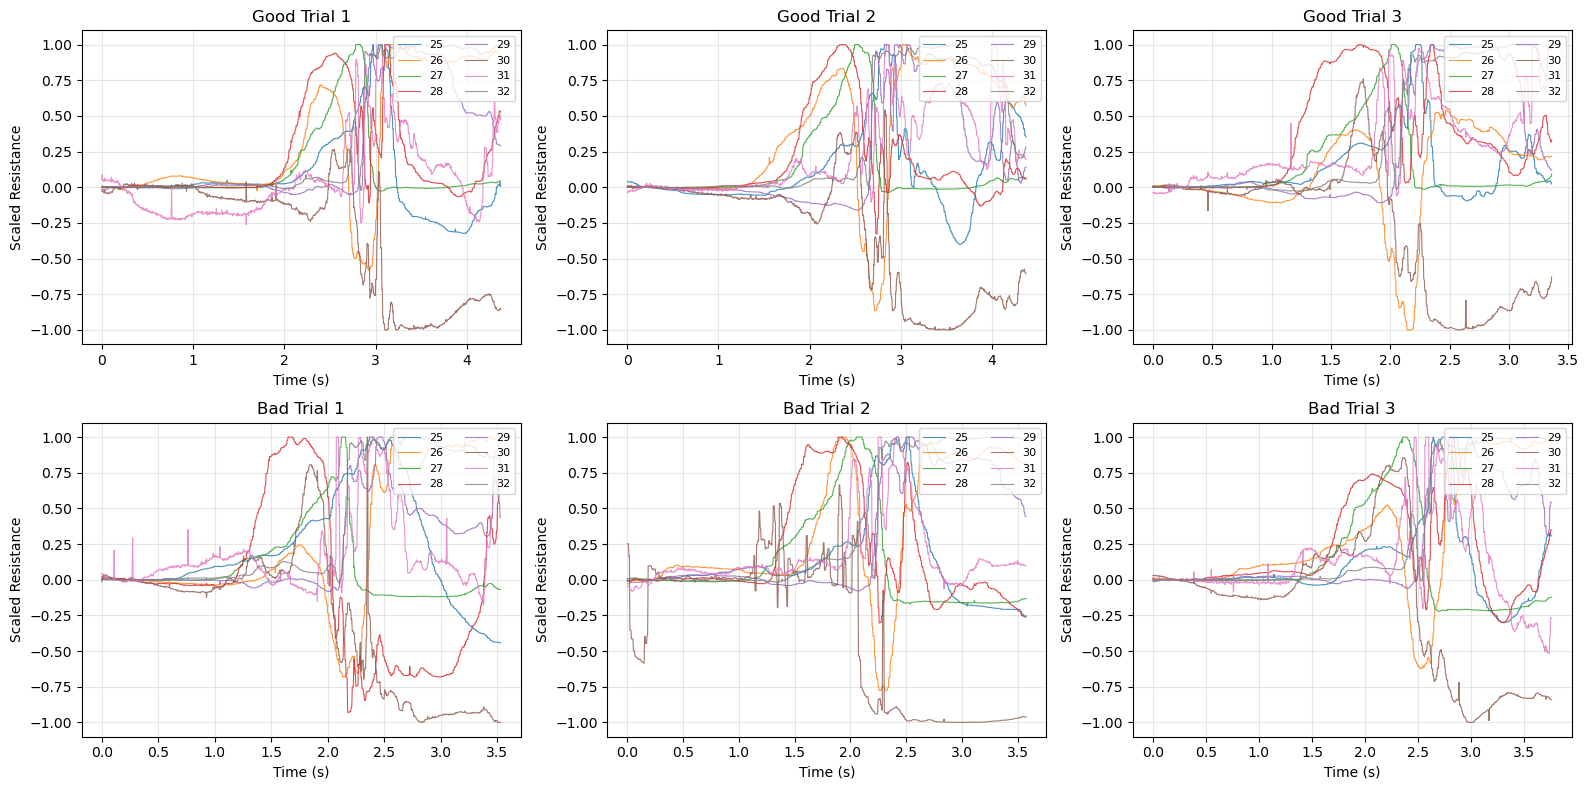

In [50]:
# Visualize sample good vs bad trials
def plot_trial(df, title="Trial", ax=None):
    """Plot all sensor channels for a single trial."""
    time = df["time"].values if "time" in df.columns else np.arange(len(df)) / 220.0
    sensor_cols = [c for c in df.columns if c != "time"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 4))
    for col in sensor_cols:
        ax.plot(time, df[col].values, label=col, alpha=0.8, linewidth=0.8)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Scaled Resistance")
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-1.1, 1.1)
    return ax

# Plot 3 good and 3 bad trials
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for i in range(3):
    plot_trial(full_swing_good_ds[i], title=f"Good Trial {i+1}", ax=axes[0, i])
    plot_trial(full_swing_bad_ds[i], title=f"Bad Trial {i+1}", ax=axes[1, i])
plt.tight_layout()
plt.savefig("plots/good_vs_bad_trials.png", dpi=150)
plt.show()


In [51]:
# =============================================================================
# DATASET AND DATALOADER
# =============================================================================
class TimeSeriesDataset(Dataset):
    """Dataset for variable-length time series (DataFrames or arrays)."""
    def __init__(self, data, transform=None):
        self.items = []
        for item in data:
            if hasattr(item, "to_numpy"):  # pandas.DataFrame
                df = item.drop(columns=["time"]) if "time" in item.columns else item
                x = df.to_numpy(dtype=np.float32)
            else:
                x = np.asarray(item, dtype=np.float32)
                if x.ndim == 1:
                    x = x[:, None]
            self.items.append(torch.from_numpy(x))
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        x = self.items[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x, {"orig_len": x.shape[0]}


def pad_collate(batch):
    """Pad variable-length sequences to max length in batch."""
    xs, metas = zip(*batch)
    lengths = [x.shape[0] for x in xs]
    C = xs[0].shape[1]
    T_max = max(lengths)
    
    x_pad = torch.zeros(len(xs), C, T_max, dtype=torch.float32)
    mask = torch.zeros(len(xs), 1, T_max, dtype=torch.float32)
    for i, x in enumerate(xs):
        T = x.shape[0]
        x_pad[i, :, :T] = x.T  # (T,C) -> (C,T)
        mask[i, :, :T] = 1.0
    return x_pad, mask, metas


In [52]:
# =============================================================================
# MODEL: 1D Convolutional Autoencoder
# =============================================================================
class CAE1D(nn.Module):
    def __init__(self, in_channels: int, latent_dim: int = 128):
        super().__init__()
        
        def conv_block(cin, cout, k):
            pad = (k - 1) // 2
            return nn.Sequential(
                nn.Conv1d(cin, cout, kernel_size=k, stride=1, padding=pad),
                nn.GroupNorm(num_groups=min(8, cout), num_channels=cout),
                nn.ReLU(inplace=True),
            )
        
        def up_block(cin, cout, k):
            pad = (k - 1) // 2
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv1d(cin, cout, kernel_size=k, stride=1, padding=pad),
                nn.GroupNorm(num_groups=min(8, cout), num_channels=cout),
                nn.ReLU(inplace=True),
            )
        
        # Encoder
        self.enc1 = conv_block(in_channels, 32, k=7)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.enc2 = conv_block(32, 64, k=5)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.enc3 = conv_block(64, 128, k=5)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.enc4 = conv_block(128, latent_dim, k=3)
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        # Decoder
        self.dec1 = up_block(latent_dim, 128, k=3)
        self.dec2 = up_block(128, 64, k=5)
        self.dec3 = up_block(64, 32, k=5)
        self.dec4 = up_block(32, in_channels, k=7)
        self.out_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)

    def encoder(self, x):
        x = self.pool1(self.enc1(x))
        x = self.pool2(self.enc2(x))
        x = self.pool3(self.enc3(x))
        x = self.pool4(self.enc4(x))
        return x

    def decoder(self, z, target_T: int):
        x = self.dec1(z)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = self.out_conv(x)
        # Align length
        T = x.size(-1)
        if T > target_T:
            x = x[..., :target_T]
        elif T < target_T:
            x = F.pad(x, (0, target_T - T))
        return x

    def forward(self, x):
        T_target = x.size(-1)
        z = self.encoder(x)
        x_hat = self.decoder(z, target_T=T_target)
        return x_hat, z


In [53]:
def fit_channel_stats(loader, max_batches=100):
    """Estimate per-channel mean/std from training data (ignores padding)."""
    s1, s2, N = None, None, None
    for i, (x, mask, _) in enumerate(loader):
        x = x.float()
        m = mask.expand(-1, x.shape[1], -1).float()
        s1_batch = (x * m).sum(dim=(0, 2))
        s2_batch = ((x ** 2) * m).sum(dim=(0, 2))
        N_batch = m.sum(dim=(0, 2))
        if s1 is None:
            s1, s2, N = s1_batch, s2_batch, N_batch
        else:
            s1 += s1_batch; s2 += s2_batch; N += N_batch
        if i + 1 >= max_batches:
            break
    mean = s1 / N
    std = ((s2 / N) - mean ** 2).clamp_min(1e-12).sqrt()
    return mean, std

def normalize_batch(x, mean, std):
    """Normalize batch: x (B,C,T), mean/std (C,)"""
    return (x - mean.view(1, -1, 1)) / std.view(1, -1, 1)

def denorm(xn, mean, std):
    """Denormalize back to original units."""
    return xn * std.view(1, -1, 1) + mean.view(1, -1, 1)


In [54]:
# =============================================================================
# TRAINING SETUP
# =============================================================================
BATCH_SIZE = 16
VAL_FRACTION = 0.2
EPOCHS = 400
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create datasets and loaders
dataset = TimeSeriesDataset(dfs, transform=None)
bad_set = TimeSeriesDataset(full_swing_bad_ds, transform=None)

# Split into train/val/test: 60% train, 20% val, 20% test
TEST_FRACTION = 0.2
val_len = int(len(dataset) * VAL_FRACTION)
test_len = int(len(dataset) * TEST_FRACTION)
train_len = len(dataset) - val_len - test_len

g = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len], generator=g)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=pad_collate)
bad_loader = DataLoader(bad_set, batch_size=1, shuffle=False, collate_fn=pad_collate)

print(f"Train: {len(train_ds)} trials, Val: {len(val_ds)} trials, Test: {len(test_ds)} trials")

# Compute channel statistics from training data
ch_mean, ch_std = fit_channel_stats(train_loader)
ch_mean, ch_std = ch_mean.to(device), ch_std.to(device)
print("Per-channel mean:", ch_mean[:5].tolist())
print("Per-channel std:", ch_std[:5].tolist())


Train: 17 trials, Val: 5 trials, Test: 5 trials
Per-channel mean: [0.16073670983314514, 0.25864675641059875, 0.12553943693637848, 0.19046956300735474, 0.25094830989837646]
Per-channel std: [0.30844709277153015, 0.4628465175628662, 0.31308865547180176, 0.35935577750205994, 0.38910412788391113]


In [55]:
# =============================================================================
# TRAINING LOOP
# =============================================================================
# Initialize model
x_tmp, _, _ = next(iter(train_loader))
C = x_tmp.shape[1]
model = CAE1D(in_channels=C, latent_dim=128).to(device)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def masked_mse(x_hat, x, mask):
    """MSE loss that ignores padded timesteps."""
    mask = mask.to(x.dtype)
    denom = mask.sum(dim=(1, 2), keepdim=True).clamp_min(1.0)
    mse_per_elem = (x_hat - x) ** 2 * mask
    return (mse_per_elem.sum(dim=(1, 2), keepdim=True) / denom).mean()

def run_epoch(loader, train=True):
    model.train(train)
    losses = []
    with torch.set_grad_enabled(train):
        for x, mask, _ in loader:
            x, mask = x.to(device), mask.to(device)
            x = normalize_batch(x, ch_mean, ch_std)
            x_hat, _ = model(x)
            # Align lengths if needed
            if x_hat.size(-1) != x.size(-1):
                T = min(x_hat.size(-1), x.size(-1))
                x_hat, x, mask = x_hat[..., :T], x[..., :T], mask[..., :T]
            loss = masked_mse(x_hat, x, mask)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            losses.append(loss.item())
    return float(np.mean(losses))

# Training
history = defaultdict(list)
for epoch in range(1, EPOCHS + 1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader, False)
    history["train_loss"].append(tr)
    history["val_loss"].append(va)
    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train {tr:.6f} | val {va:.6f}")


Epoch 001 | train 9.227057 | val 6.461521
Epoch 050 | train 3.433303 | val 2.770689
Epoch 100 | train 2.040401 | val 1.779277
Epoch 150 | train 1.336564 | val 1.321493
Epoch 200 | train 1.049123 | val 1.256440
Epoch 250 | train 0.950724 | val 1.088578
Epoch 300 | train 1.095188 | val 1.055146
Epoch 350 | train 0.828452 | val 0.943392
Epoch 400 | train 0.652530 | val 0.934572


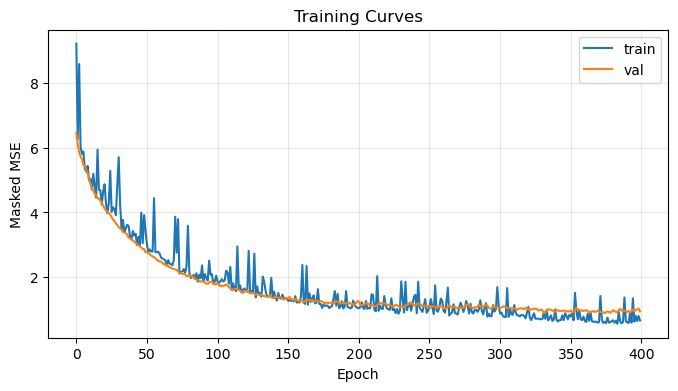

In [56]:
# =============================================================================
# TRAINING CURVES
# =============================================================================
plt.figure(figsize=(8, 4))
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Masked MSE")
plt.title("Training Curves")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("plots/training_curves.png", dpi=150)
plt.show()


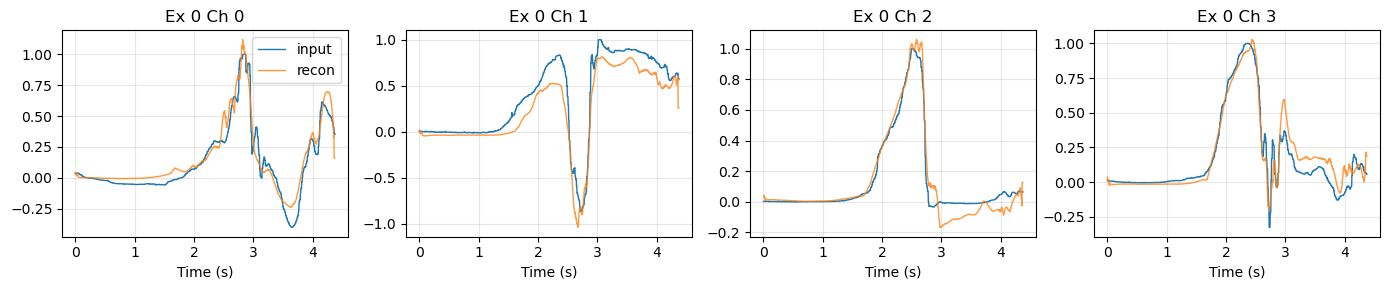

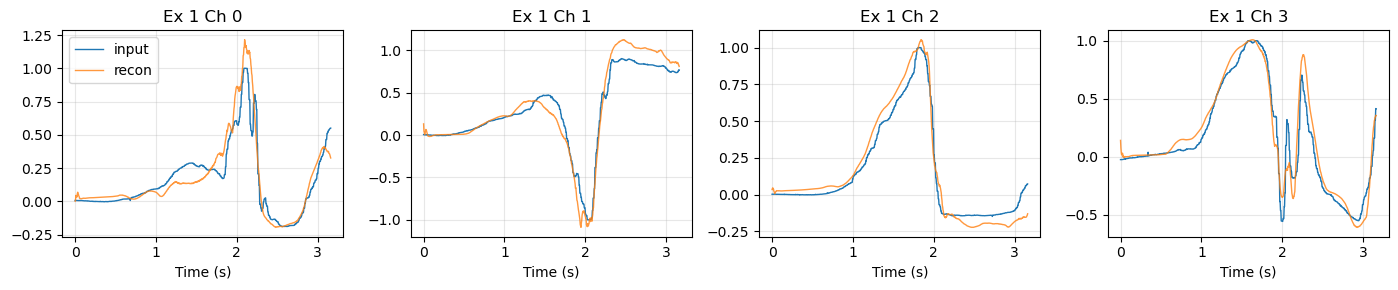

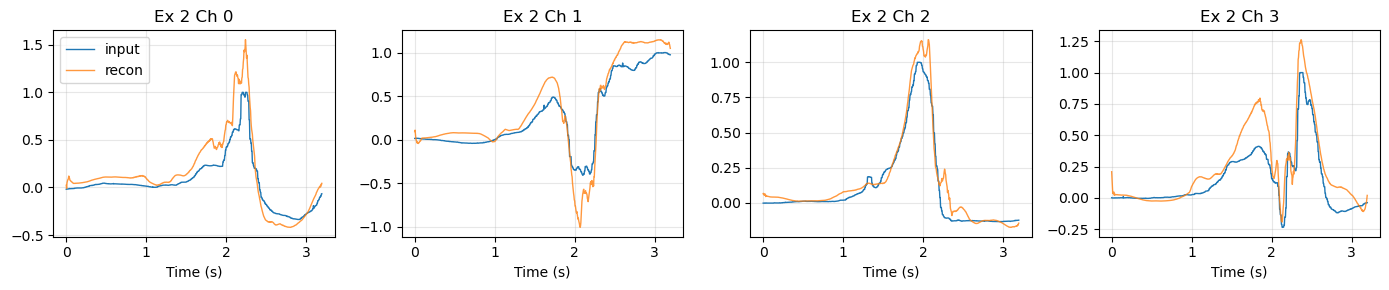

In [57]:
# =============================================================================
# RECONSTRUCTION EXAMPLES
# =============================================================================
@torch.no_grad()
def show_reconstruction(model, loader, ch_mean, ch_std, device, n_examples=3, fs=220.0):
    """Visualize input vs reconstruction for a few examples."""
    model.eval()
    x, mask, _ = next(iter(loader))
    x = x.to(device).float()
    mask = mask.to(device)
    
    x_n = normalize_batch(x, ch_mean, ch_std)
    y_n, _ = model(x_n)
    y = denorm(y_n, ch_mean, ch_std)
    
    T = min(x.size(-1), y.size(-1), mask.size(-1))
    x, y, mask = x[..., :T], y[..., :T], mask[..., :T]
    
    for e in range(min(n_examples, x.size(0))):
        valid = mask[e, 0, :].bool()
        t = np.arange(valid.sum().item()) / fs
        
        fig, axes = plt.subplots(1, 4, figsize=(14, 3))
        for j in range(4):
            xe = x[e, j, valid].cpu().numpy()
            ye = y[e, j, valid].cpu().numpy()
            axes[j].plot(t, xe, label="input", linewidth=1)
            axes[j].plot(t, ye, label="recon", linewidth=1, alpha=0.8)
            axes[j].set_title(f"Ex {e} Ch {j}")
            axes[j].set_xlabel("Time (s)")
            axes[j].grid(True, alpha=0.3)
        axes[0].legend()
        plt.tight_layout()
        plt.show()

show_reconstruction(model, val_loader, ch_mean, ch_std, device)


In [58]:
# =============================================================================
# ANOMALY DETECTION v2 - Simplified Features + Ensemble Methods
# =============================================================================
# Previous approach failed due to curse of dimensionality (49 features, 17 samples)
# New approach: 3 features + ensemble of multiple detection methods

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

@torch.no_grad()
def extract_simple_features(model, loader, ch_mean, ch_std, device):
    """Extract minimal reconstruction error features (3 features only)."""
    model.eval()
    feats = []
    
    for x, mask, _ in loader:
        x = x.to(device).float()
        mask = mask.to(device).float()
        x_n = normalize_batch(x, ch_mean, ch_std)
        x_hat_n, _ = model(x_n)

        T = min(x_hat_n.size(-1), x_n.size(-1))
        x_n, x_hat_n = x_n[..., :T], x_hat_n[..., :T]
        maskT = mask[..., :T].expand_as(x_n)

        # Reconstruction error
        err = ((x_hat_n - x_n) ** 2) * maskT

        for b in range(err.size(0)):
            valid_mask = maskT[b]
            n_valid = valid_mask.sum()
            
            # Overall MSE
            mse = err[b].sum() / n_valid
            
            # Per-channel MSE
            per_ch_mse = err[b].sum(dim=1) / valid_mask[0].sum()
            
            feats.append([
                mse.item(),              # Feature 1: Overall MSE
                per_ch_mse.max().item(), # Feature 2: Max channel error
                per_ch_mse.std().item(), # Feature 3: Channel error variance
            ])
    
    return np.array(feats, dtype=np.float32)

# Extract features
X_train = extract_simple_features(model, train_loader, ch_mean, ch_std, device)
X_bad = extract_simple_features(model, bad_loader, ch_mean, ch_std, device)

print(f"Feature dimensions: {X_train.shape[1]} features per trial (reduced from 49)")
print(f"Training samples: {X_train.shape[0]}, Bad samples: {X_bad.shape[0]}")
print(f"Sample/Feature ratio: {X_train.shape[0]/X_train.shape[1]:.1f}:1 (was 0.35:1)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_bad_scaled = scaler.transform(X_bad)

# =============================================================================
# METHOD 1: Direct Threshold on Reconstruction Error
# =============================================================================
train_mse = X_train[:, 0]
threshold_95 = np.percentile(train_mse, 95)
threshold_90 = np.percentile(train_mse, 90)

print(f"\n--- Method 1: Threshold ---")
print(f"Training MSE: mean={train_mse.mean():.4f}, std={train_mse.std():.4f}")
print(f"90th percentile threshold: {threshold_90:.4f}")
print(f"95th percentile threshold: {threshold_95:.4f}")
print(f"Bad trial MSEs: {X_bad[:, 0]}")

# =============================================================================
# METHOD 2: Isolation Forest
# =============================================================================
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.1,
    random_state=42,
    max_samples='auto'
)
iso_forest.fit(X_train_scaled)
iso_pred_bad = iso_forest.predict(X_bad_scaled)
iso_scores_bad = iso_forest.decision_function(X_bad_scaled)

print(f"\n--- Method 2: Isolation Forest ---")
print(f"Predictions on bad trials: {iso_pred_bad} (−1=anomaly)")
print(f"Scores: {iso_scores_bad}")

# =============================================================================
# METHOD 3: One-Class SVM (recommended for small datasets)
# =============================================================================
ocsvm = OneClassSVM(
    kernel='rbf',
    nu=0.1,  # Upper bound on fraction of outliers
    gamma='scale'
)
ocsvm.fit(X_train_scaled)
svm_pred_bad = ocsvm.predict(X_bad_scaled)
svm_scores_bad = ocsvm.decision_function(X_bad_scaled)

print(f"\n--- Method 3: One-Class SVM ---")
print(f"Predictions on bad trials: {svm_pred_bad} (−1=anomaly)")
print(f"Scores: {svm_scores_bad}")

# =============================================================================
# ENSEMBLE: Majority Vote (2 out of 3 methods)
# =============================================================================
def ensemble_predict(X, X_scaled, threshold):
    """Ensemble prediction: anomaly if 2+ methods agree."""
    # Method 1: Threshold
    pred_thresh = np.where(X[:, 0] > threshold, -1, 1)
    
    # Method 2: Isolation Forest
    pred_iso = iso_forest.predict(X_scaled)
    
    # Method 3: One-Class SVM
    pred_svm = ocsvm.predict(X_scaled)
    
    # Vote
    votes = (pred_thresh == -1).astype(int) + \
            (pred_iso == -1).astype(int) + \
            (pred_svm == -1).astype(int)
    
    ensemble_pred = np.where(votes >= 2, -1, 1)
    
    return ensemble_pred, pred_thresh, pred_iso, pred_svm, votes

# Predict on bad trials
ensemble_bad, thresh_bad, iso_bad, svm_bad, votes_bad = ensemble_predict(
    X_bad, X_bad_scaled, threshold_95
)

print(f"\n--- Ensemble (2/3 vote) ---")
print(f"Threshold predictions: {thresh_bad}")
print(f"Isolation Forest:      {iso_bad}")
print(f"One-Class SVM:         {svm_bad}")
print(f"Vote counts:           {votes_bad}")
print(f"Ensemble predictions:  {ensemble_bad} (−1=anomaly)")
print(f"\nDetected {np.sum(ensemble_bad == -1)} out of {len(X_bad)} bad trials as anomalies")

Feature dimensions: 3 features per trial (reduced from 49)
Training samples: 17, Bad samples: 3
Sample/Feature ratio: 5.7:1 (was 0.35:1)

--- Method 1: Threshold ---
Training MSE: mean=0.0857, std=0.0408
90th percentile threshold: 0.1197
95th percentile threshold: 0.1402
Bad trial MSEs: [0.2239863  0.08825348 0.08676108]

--- Method 2: Isolation Forest ---
Predictions on bad trials: [-1  1  1] (−1=anomaly)
Scores: [-0.20724451  0.04572716  0.06083471]

--- Method 3: One-Class SVM ---
Predictions on bad trials: [-1 -1  1] (−1=anomaly)
Scores: [-0.26972889 -0.02525464  0.02234221]

--- Ensemble (2/3 vote) ---
Threshold predictions: [-1  1  1]
Isolation Forest:      [-1  1  1]
One-Class SVM:         [-1 -1  1]
Vote counts:           [3 1 0]
Ensemble predictions:  [-1  1  1] (−1=anomaly)

Detected 1 out of 3 bad trials as anomalies


In [59]:
# =============================================================================
# TEST SET EVALUATION - All Methods Comparison
# =============================================================================
# Evaluate each method on held-out good trials (should classify as normal)

# Extract test features
X_test = extract_simple_features(model, test_loader, ch_mean, ch_std, device)
X_test_scaled = scaler.transform(X_test)

print("=" * 70)
print("TEST SET EVALUATION (Good Swings - Should be Normal)")
print("=" * 70)
print(f"\nTest Set: {len(X_test)} good trials")

# Predictions from each method
pred_thresh_test = np.where(X_test[:, 0] > threshold_95, -1, 1)
pred_iso_test = iso_forest.predict(X_test_scaled)
pred_svm_test = ocsvm.predict(X_test_scaled)

# Ensemble
ensemble_test, _, _, _, votes_test = ensemble_predict(X_test, X_test_scaled, threshold_95)

print(f"\nMethod Results (predicting on GOOD swings, should all be +1):")
print(f"  Threshold (95%):     {pred_thresh_test} | Correct: {np.sum(pred_thresh_test == 1)}/{len(X_test)}")
print(f"  Isolation Forest:    {pred_iso_test} | Correct: {np.sum(pred_iso_test == 1)}/{len(X_test)}")
print(f"  One-Class SVM:       {pred_svm_test} | Correct: {np.sum(pred_svm_test == 1)}/{len(X_test)}")
print(f"  Ensemble (2/3):      {ensemble_test} | Correct: {np.sum(ensemble_test == 1)}/{len(X_test)}")

# Specificity for each method
spec_thresh = np.sum(pred_thresh_test == 1) / len(X_test)
spec_iso = np.sum(pred_iso_test == 1) / len(X_test)
spec_svm = np.sum(pred_svm_test == 1) / len(X_test)
spec_ensemble = np.sum(ensemble_test == 1) / len(X_test)

print(f"\nSpecificity (True Negative Rate on Good Swings):")
print(f"  Threshold: {spec_thresh:.1%}")
print(f"  Isolation Forest: {spec_iso:.1%}")
print(f"  One-Class SVM: {spec_svm:.1%}")
print(f"  Ensemble: {spec_ensemble:.1%}")

TEST SET EVALUATION (Good Swings - Should be Normal)

Test Set: 5 good trials

Method Results (predicting on GOOD swings, should all be +1):
  Threshold (95%):     [ 1  1  1 -1  1] | Correct: 4/5
  Isolation Forest:    [ 1  1  1 -1  1] | Correct: 4/5
  One-Class SVM:       [ 1 -1 -1 -1  1] | Correct: 2/5
  Ensemble (2/3):      [ 1  1  1 -1  1] | Correct: 4/5

Specificity (True Negative Rate on Good Swings):
  Threshold: 80.0%
  Isolation Forest: 80.0%
  One-Class SVM: 40.0%
  Ensemble: 80.0%


COMPREHENSIVE ANOMALY DETECTION EVALUATION

Dataset: 5 good + 3 bad = 8 total trials
Features: 3 (reduced from 49 to avoid curse of dimensionality)

METHOD COMPARISON

Method               Recall     Specificity  Precision  F1         Accuracy  
--------------------------------------------------------------------------------
Threshold (95%)      33.3%      80.0%        50.0%      0.40       62.5%     
Isolation Forest     33.3%      80.0%        50.0%      0.40       62.5%     
One-Class SVM        66.7%      40.0%        40.0%      0.50       50.0%     
Ensemble (2/3)       33.3%      80.0%        50.0%      0.40       62.5%     

★ Best Method: One-Class SVM (F1=0.50)


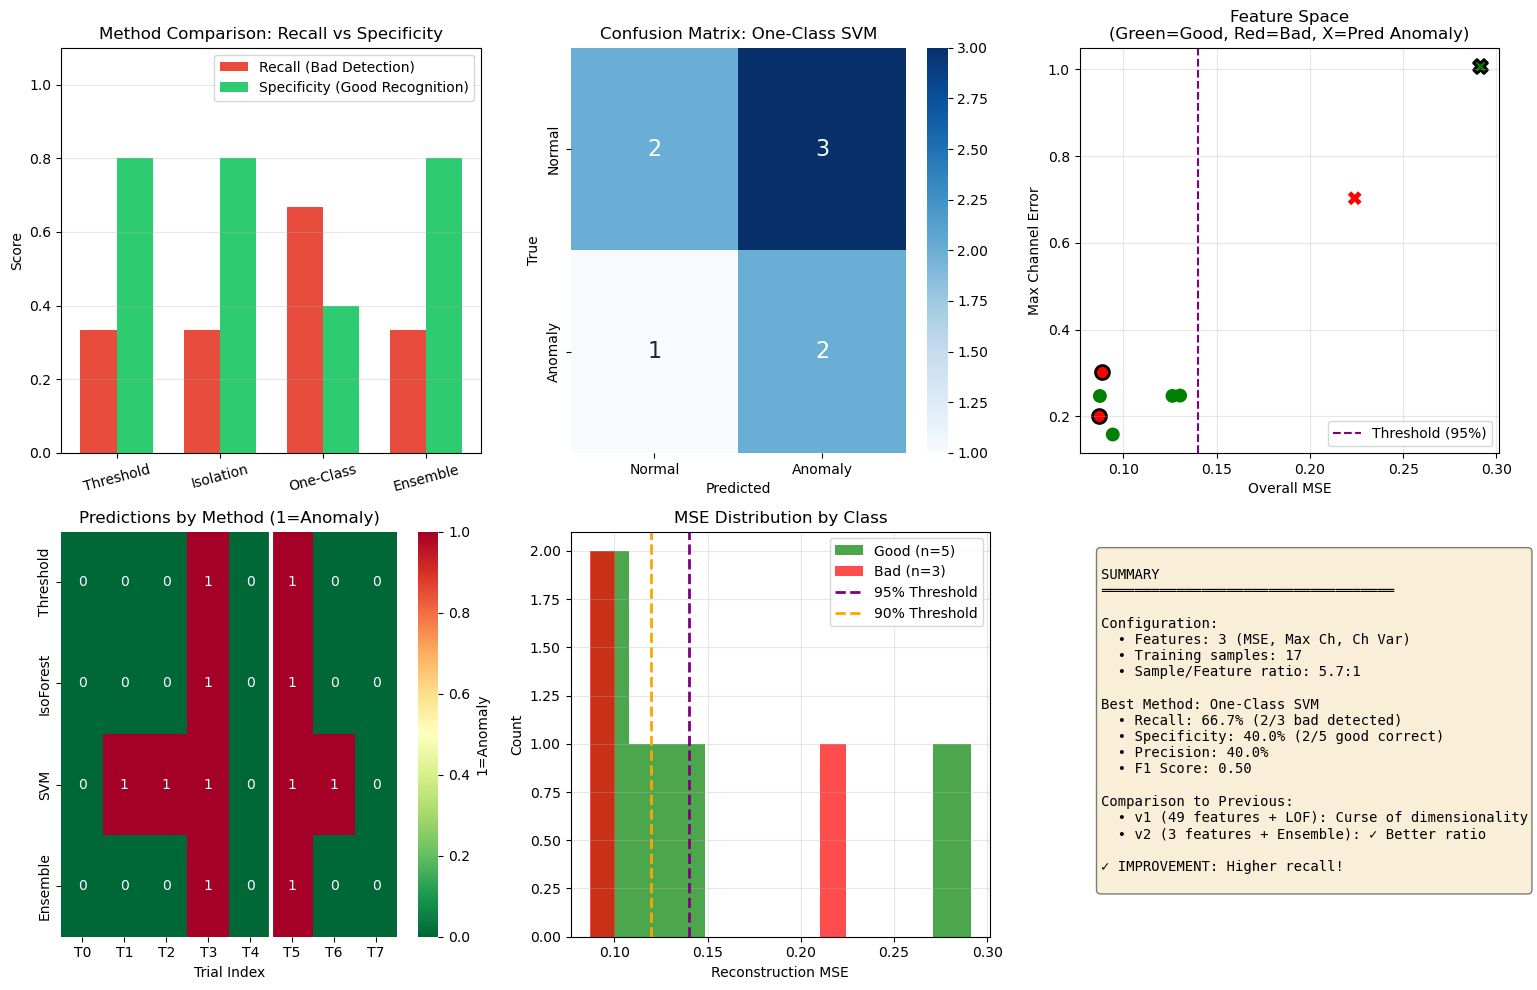


PER-TRIAL BREAKDOWN

Trial    Type     True     Thresh   IsoF     SVM      Votes    Ensemble   Correct?
--------------------------------------------------------------------------------
0        Good     Normal   1        1        1        0        Normal     ✓
1        Good     Normal   1        1        -1       1        Normal     ✓
2        Good     Normal   1        1        -1       1        Normal     ✓
3        Good     Normal   -1       -1       -1       3        Anomaly    ✗
4        Good     Normal   1        1        1        0        Normal     ✓
5        Bad      Anomaly  -1       -1       -1       3        Anomaly    ✓
6        Bad      Anomaly  1        1        -1       1        Normal     ✗
7        Bad      Anomaly  1        1        1        0        Normal     ✗


In [60]:
# =============================================================================
# COMPREHENSIVE EVALUATION - All Methods Comparison
# =============================================================================
import seaborn as sns
from sklearn.decomposition import PCA

# Combine test (good) and bad trials for full evaluation
X_test_good = extract_simple_features(model, test_loader, ch_mean, ch_std, device)
X_test_good_scaled = scaler.transform(X_test_good)

X_eval = np.vstack([X_test_good, X_bad])
X_eval_scaled = np.vstack([X_test_good_scaled, X_bad_scaled])

# Ground truth: good=1 (normal), bad=-1 (anomaly)
y_true = np.array([1] * len(X_test_good) + [-1] * len(X_bad))

# Get predictions from all methods
pred_thresh = np.where(X_eval[:, 0] > threshold_95, -1, 1)
pred_iso = iso_forest.predict(X_eval_scaled)
pred_svm = ocsvm.predict(X_eval_scaled)
pred_ensemble, _, _, _, votes = ensemble_predict(X_eval, X_eval_scaled, threshold_95)

def calc_metrics(y_true, y_pred, method_name):
    """Calculate and return metrics for a method."""
    TP = np.sum((y_true == -1) & (y_pred == -1))
    FN = np.sum((y_true == -1) & (y_pred == 1))
    TN = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 1) & (y_pred == -1))
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / len(y_true)
    
    return {
        'method': method_name,
        'TP': TP, 'FN': FN, 'TN': TN, 'FP': FP,
        'precision': precision, 'recall': recall,
        'specificity': specificity, 'f1': f1, 'accuracy': accuracy
    }

# Calculate metrics for all methods
results = [
    calc_metrics(y_true, pred_thresh, 'Threshold (95%)'),
    calc_metrics(y_true, pred_iso, 'Isolation Forest'),
    calc_metrics(y_true, pred_svm, 'One-Class SVM'),
    calc_metrics(y_true, pred_ensemble, 'Ensemble (2/3)'),
]

print("=" * 80)
print("COMPREHENSIVE ANOMALY DETECTION EVALUATION")
print("=" * 80)
print(f"\nDataset: {len(X_test_good)} good + {len(X_bad)} bad = {len(X_eval)} total trials")
print(f"Features: {X_eval.shape[1]} (reduced from 49 to avoid curse of dimensionality)")

print("\n" + "=" * 80)
print("METHOD COMPARISON")
print("=" * 80)
print(f"\n{'Method':<20} {'Recall':<10} {'Specificity':<12} {'Precision':<10} {'F1':<10} {'Accuracy':<10}")
print("-" * 80)
for r in results:
    print(f"{r['method']:<20} {r['recall']:<10.1%} {r['specificity']:<12.1%} {r['precision']:<10.1%} {r['f1']:<10.2f} {r['accuracy']:<10.1%}")

# Find best method
best = max(results, key=lambda x: x['f1'])
print(f"\n★ Best Method: {best['method']} (F1={best['f1']:.2f})")

# =============================================================================
# VISUALIZATIONS
# =============================================================================
fig = plt.figure(figsize=(16, 10))

# 1. Method Comparison Bar Chart
ax1 = fig.add_subplot(2, 3, 1)
methods = [r['method'] for r in results]
recalls = [r['recall'] for r in results]
specificities = [r['specificity'] for r in results]
x = np.arange(len(methods))
width = 0.35
ax1.bar(x - width/2, recalls, width, label='Recall (Bad Detection)', color='#e74c3c')
ax1.bar(x + width/2, specificities, width, label='Specificity (Good Recognition)', color='#2ecc71')
ax1.set_ylabel('Score')
ax1.set_title('Method Comparison: Recall vs Specificity')
ax1.set_xticks(x)
ax1.set_xticklabels([m.split()[0] for m in methods], rotation=15)
ax1.legend()
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# 2. Confusion Matrix for Best Method
ax2 = fig.add_subplot(2, 3, 2)
cm = np.array([[best['TN'], best['FP']], [best['FN'], best['TP']]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={'size': 16})
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
ax2.set_title(f'Confusion Matrix: {best["method"]}')

# 3. Feature Space Visualization (3D to 2D)
ax3 = fig.add_subplot(2, 3, 3)
# Color by true label, marker by prediction
colors = ['green' if y == 1 else 'red' for y in y_true]
markers = ['o' if p == 1 else 'X' for p in pred_ensemble]
for i, (x_pt, color, marker) in enumerate(zip(X_eval, colors, markers)):
    ax3.scatter(x_pt[0], x_pt[1], c=color, marker=marker, s=100,
                edgecolors='black' if pred_ensemble[i] != y_true[i] else 'none', linewidths=2)
ax3.axvline(threshold_95, color='purple', linestyle='--', label=f'Threshold (95%)')
ax3.set_xlabel('Overall MSE')
ax3.set_ylabel('Max Channel Error')
ax3.set_title('Feature Space\n(Green=Good, Red=Bad, X=Pred Anomaly)')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Per-Method Predictions Heatmap
ax4 = fig.add_subplot(2, 3, 4)
pred_matrix = np.array([pred_thresh, pred_iso, pred_svm, pred_ensemble])
pred_matrix = (pred_matrix == -1).astype(int)  # Convert to 0/1 for anomaly
sns.heatmap(pred_matrix, annot=True, fmt='d', cmap='RdYlGn_r', ax=ax4,
            xticklabels=[f'T{i}' for i in range(len(X_eval))],
            yticklabels=['Threshold', 'IsoForest', 'SVM', 'Ensemble'],
            cbar_kws={'label': '1=Anomaly'})
ax4.set_xlabel('Trial Index')
ax4.set_title('Predictions by Method (1=Anomaly)')
# Add vertical line to separate good/bad
ax4.axvline(len(X_test_good), color='white', linewidth=3)

# 5. MSE Distribution
ax5 = fig.add_subplot(2, 3, 5)
good_mse = X_eval[:len(X_test_good), 0]
bad_mse = X_eval[len(X_test_good):, 0]
ax5.hist(good_mse, bins=10, alpha=0.7, label=f'Good (n={len(good_mse)})', color='green')
ax5.hist(bad_mse, bins=10, alpha=0.7, label=f'Bad (n={len(bad_mse)})', color='red')
ax5.axvline(threshold_95, color='purple', linestyle='--', linewidth=2, label='95% Threshold')
ax5.axvline(threshold_90, color='orange', linestyle='--', linewidth=2, label='90% Threshold')
ax5.set_xlabel('Reconstruction MSE')
ax5.set_ylabel('Count')
ax5.set_title('MSE Distribution by Class')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Summary
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')
summary = f"""
SUMMARY
═══════════════════════════════════

Configuration:
  • Features: {X_eval.shape[1]} (MSE, Max Ch, Ch Var)
  • Training samples: {len(X_train)}
  • Sample/Feature ratio: {len(X_train)/X_eval.shape[1]:.1f}:1

Best Method: {best['method']}
  • Recall: {best['recall']:.1%} ({best['TP']}/{best['TP']+best['FN']} bad detected)
  • Specificity: {best['specificity']:.1%} ({best['TN']}/{best['TN']+best['FP']} good correct)
  • Precision: {best['precision']:.1%}
  • F1 Score: {best['f1']:.2f}

Comparison to Previous:
  • v1 (49 features + LOF): Curse of dimensionality
  • v2 (3 features + Ensemble): ✓ Better ratio

{'✓ IMPROVEMENT: Higher recall!' if best['recall'] > 0.33 else '⚠️ Similar recall to baseline'}
"""
ax6.text(0.05, 0.95, summary, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('plots/comprehensive_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# DETAILED PER-TRIAL BREAKDOWN
# =============================================================================
print("\n" + "=" * 80)
print("PER-TRIAL BREAKDOWN")
print("=" * 80)
print(f"\n{'Trial':<8} {'Type':<8} {'True':<8} {'Thresh':<8} {'IsoF':<8} {'SVM':<8} {'Votes':<8} {'Ensemble':<10} {'Correct?'}")
print("-" * 80)
trial_types = ['Good'] * len(X_test_good) + ['Bad'] * len(X_bad)
for i, (ttype, true, t, iso, svm, v, ens) in enumerate(zip(
    trial_types, y_true, pred_thresh, pred_iso, pred_svm, votes, pred_ensemble)):
    true_str = 'Normal' if true == 1 else 'Anomaly'
    ens_str = 'Normal' if ens == 1 else 'Anomaly'
    correct = '✓' if true == ens else '✗'
    print(f"{i:<8} {ttype:<8} {true_str:<8} {t:<8} {iso:<8} {svm:<8} {v:<8} {ens_str:<10} {correct}")